<a href="https://colab.research.google.com/github/sumanmichael/unet-coco/blob/main/Unet_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Processing

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import tensorflow as tf
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [ ]:
dataDir='.'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [ ]:
def get_image(imgId,as_gray=True):
    img = coco.loadImgs(ids=[imgId])[0]
    yield np.array(io.imread(img['coco_url'],as_gray=as_gray))

In [ ]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds );
print(max(imgIds))
# imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

581357


(480, 640)
150417


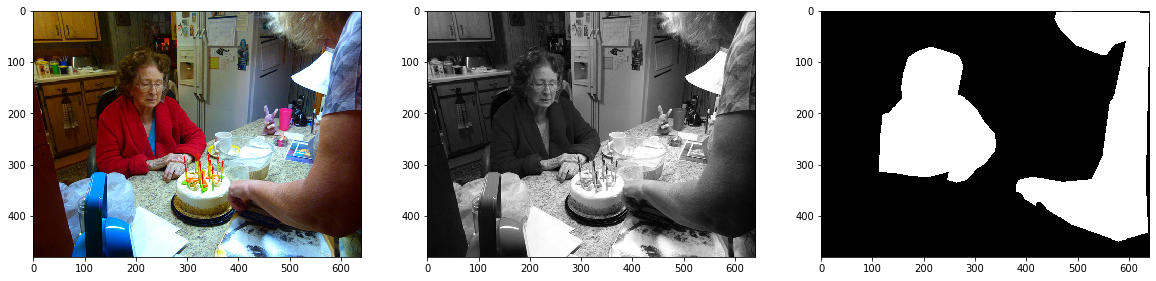

In [ ]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'],as_gray=True)
I_color = io.imread(img['coco_url'])
print(I.shape)
print(img['id'])
# extracting mask inform of 0 & 1
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
mask = np.zeros(I.shape[:2]).astype(np.float)
for ann in anns:
    mask += cocomask.decode(coco.annToRLE(ann))
#     mask += coco.annToMask(ann)
    
    
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(I_color)
plt.subplot(132)
plt.imshow(I,cmap='gray')
plt.subplot(133)
plt.imshow(mask,cmap='gray',vmin=0,vmax=1)
plt.show()

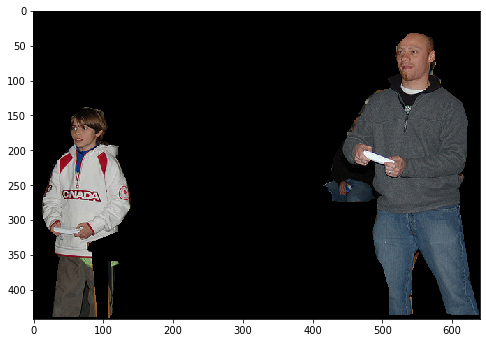

In [ ]:
def show_masked_rgb(I_color,mask):
    mask_filter = mask.astype(np.bool)[:,:,np.newaxis]
    mask_rgb = np.repeat(mask_filter,3,axis=2)
    filtered = np.where(mask_rgb==1,I_color,0)
    plt.imshow(filtered)
#     return filtered

show_masked_rgb(I_color,mask)  

# Keras_Model

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)

In [ ]:
list_ds = tf.data.Dataset.list_files(str('val2017/*'))

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'val2017/000000226903.jpg'
b'val2017/000000235057.jpg'
b'val2017/000000273232.jpg'
b'val2017/000000047010.jpg'
b'val2017/000000172617.jpg'


In [ ]:
image_count = len(imgIds)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
  
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
def get_mask_img(imgId,imgShape):
    annIds = coco.getAnnIds(imgIds=int(imgId), catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    mask = np.zeros(imgShape[:2]).astype(np.float32)
    for ann in anns:
        mask += cocomask.decode(coco.annToRLE(ann))
    mask=mask[:,:,np.newaxis]
#     return tf.image.resize(mask, [IMG_WIDTH, IMG_HEIGHT])
    return mask


def process_path(file_path):
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    masked_img = get_mask_img(file_path[-10:-4],img.shape)
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

    return img,masked_img


In [ ]:
im1, im2 = process_path(b'val2017/000000083172.jpg')

In [ ]:
from tensorflow.keras.preprocessing.image import save_img
save_img("x.jpg",im2)

In [ ]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

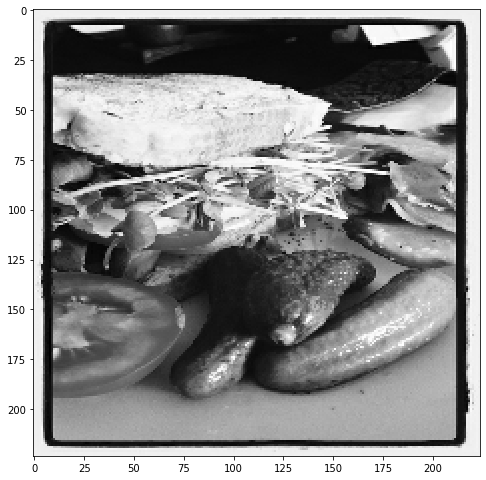

In [ ]:
for i in labeled_ds.take():
#     print(i.numpy())
    plt.imshow(i.numpy()[:,:,0],cmap='gray')

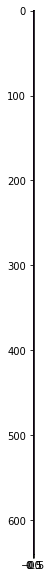

In [ ]:
def get_mask_img(imgId,imgShape):
    annIds = coco.getAnnIds(imgIds=int(imgId), catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    mask = np.zeros(imgShape).astype(np.float)
    for ann in anns:
        mask += cocomask.decode(coco.annToRLE(ann))
    return mask[:,:,np.newaxis]
plt.imshow(get_mask_img(8211,(459,640))[0])

In [ ]:
m_img = get_mask_img(8211,(459,640))
m_img.shape

(459, 640, 1)

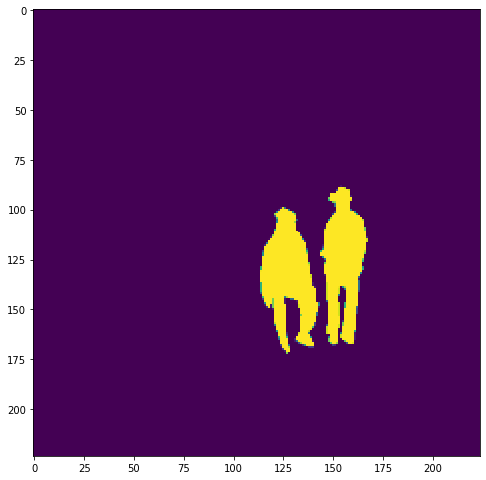

In [ ]:
tf.image.resize(m_img, [IMG_WIDTH, IMG_HEIGHT])